## `Speculator`: tau, Z, Dust

`speculator` takes physical parameters and predict PCA coeffs, spectra, and also magnitudes. 

This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi
import torch
from torch import Tensor

ModuleNotFoundError: No module named 'scarlet.operators_pybind11'

In [ ]:
kuaizi.set_matplotlib(style='nature', usetex=False)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

In [ ]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, interp_nan

In [ ]:
params = np.concatenate([np.load(f'./train_sed/fsps.TZD.v0.1.theta.seed{i+1}.npy')
                         for i in range(5)])
params = params[:, :4]

In [ ]:
log_spec = np.concatenate([np.load(f'./train_sed/fsps.TZD.v0.1.log10spectrum.seed{i+1}.npy')
                           for i in range(5)])
log_spec = interp_nan(log_spec)[:, 100:]
# Very large...

In [ ]:
zero_flag = (np.mean(log_spec, axis=1) < -30)

log_spec = log_spec[~zero_flag]
params = params[~zero_flag]
pca_coeff = np.load('./train_sed/fsps.pca_coeffs.npy')[~zero_flag]
# # This zero_flag is SUPER IMPORTANT!!!

In [ ]:
params[:, 1] = np.log10(params[:, 1]) # tau to log(tau)

In [ ]:
pca_coeff.shape

`params: tage, log tau, logzsol, dust2`

In [ ]:
dlambda_spec = 2
wave_lo = 1200 # 1000
wave_hi = 15000
wavelengths = np.arange(wave_lo, wave_hi, dlambda_spec)

In [11]:
speculator = Speculator(n_parameters=4,
                        pca_filename='./train_sed/fsps_pca_trained_TZD.pkl', 
                        hidden_size=[256, 256, 256])

In [12]:
speculator.load_data(pca_coeff[:10000], params[:10000], 
                     params_name=['tage', 'logtau', 'logzsol', 'dust2'],
                     val_frac=0.1, batch_size=256, 
                     wave_rest=torch.arange(wave_lo, wave_hi, dlambda_spec), 
                     wave_obs=torch.arange(wave_lo, wave_hi, dlambda_spec))

train_ind = speculator.dataloaders['train'].dataset.indices
val_ind = speculator.dataloaders['val'].dataset.indices

In [13]:
%%time
n_ep = [200, 200, 150, 500]
for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4]):
    speculator.train(learning_rate=lr, n_epochs=n_ep[i])

Epoch: 0 - train Loss: 0.0037
Epoch: 0 - val Loss: 0.0342
Epoch: 100 - train Loss: 0.0003
Epoch: 100 - val Loss: 0.0029
Epoch: 0 - train Loss: 0.0002
Epoch: 0 - val Loss: 0.0016
Epoch: 100 - train Loss: 0.0001
Epoch: 100 - val Loss: 0.0011
Epoch: 0 - train Loss: 0.0001
Epoch: 0 - val Loss: 0.0008
Epoch: 100 - train Loss: 0.0001
Epoch: 100 - val Loss: 0.0007
Epoch: 0 - train Loss: 0.0001
Epoch: 0 - val Loss: 0.0006
Epoch: 100 - train Loss: 0.0001
Epoch: 100 - val Loss: 0.0006
Epoch: 200 - train Loss: 0.0001
Epoch: 200 - val Loss: 0.0005
Epoch: 300 - train Loss: 0.0001
Epoch: 300 - val Loss: 0.0005
Epoch: 400 - train Loss: 0.0000
Epoch: 400 - val Loss: 0.0005
CPU times: user 5min 57s, sys: 7min 42s, total: 13min 40s
Wall time: 14min 28s


In [98]:
# %%time
# # n_ep = [100, 100, 150, 500, 500]
# # for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 1e-4]):
# n_ep = [200, 200, 200, 200, 200]
# for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 2e-4]):
#     speculator.train(learning_rate=lr, n_epochs=n_ep[i])

In [15]:
speculator.best_recon_err_epoch

AttributeError: 'Speculator' object has no attribute 'best_recon_err_epoch'

In [16]:
speculator.best_loss_epoch

475

[autoreload of kuaizi failed: Traceback (most recent call last):
  File "/scratch/gpfs/jiaxuanl/torch-env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/scratch/gpfs/jiaxuanl/torch-env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/scratch/gpfs/jiaxuanl/torch-env/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/scratch/gpfs/jiaxuanl/torch-env/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/jiaxuanl/Research/Packages/kuaizi/kuaizi/__init__.py", line 51, in <module>
    from . import measure
  File "/home/jiaxuanl/Resea

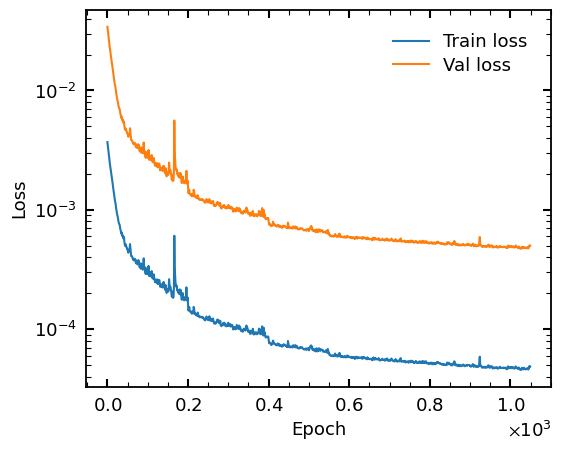

In [14]:
speculator.plot_loss()

In [ ]:
## Load the NN emulator `speculator`
with open('./speculator_best_loss_model.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [17]:
params[:1000]

array([[ 9.03937708, -0.56263802,  0.19681437,  1.33428083],
       [ 5.28894926,  1.78012161, -1.89515012,  0.96790549],
       [12.10059415,  1.34136094, -0.29531189,  1.19969273],
       ...,
       [ 7.63149212, -1.54456562, -1.67777037,  1.14041584],
       [ 2.3138302 , -1.08813538, -0.34346283,  2.0665785 ],
       [12.92236806, -1.54789821,  0.35165914,  0.05963001]])

In [ ]:
_specs = speculator.predict_spec(torch.Tensor(params[:1000])).cpu().detach().numpy()

In [ ]:
plt.plot(np.log10(_specs)[10])
plt.plot(log_spec[10])

In [19]:
plt.plot(np.nanmedian(np.log10(_specs) - log_spec[:1000], axis=0))

ValueError: operands could not be broadcast together with shapes (1000,6900) (1000,7000) 

In [60]:
diff = (10**log_spec[:1000] - _specs) / 10**log_spec[:1000] * 100
# diff = diff[val_ind]

In [61]:
from scipy.stats import norm

(200.0, 1100.0)

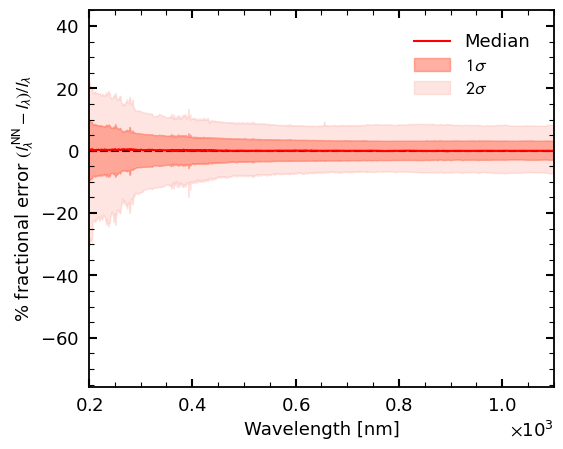

In [65]:
x = wavelengths / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')
plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

#plt.ylim(-0.008, 0.008)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.hlines(0, 200, 1100, ls='--', color='k')
plt.legend()

plt.xlim(200, 1100)

(200.0, 1100.0)

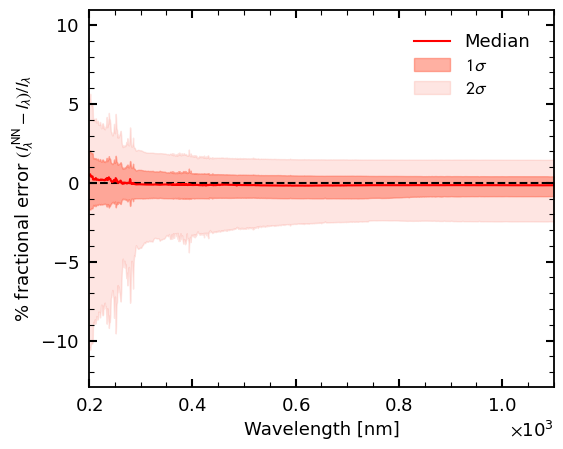

In [107]:
x = wavelengths / 10
plt.plot(x, np.median(diff, axis=0), color='r', label='Median')
plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

#plt.ylim(-0.008, 0.008)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.hlines(0, 200, 1100, ls='--', color='k')
plt.legend()

plt.xlim(200, 1100)

In [108]:
val_ind[20]

707

Text(0, 0.5, 'Flux Density (normalized to 1 $M_\\odot$)')

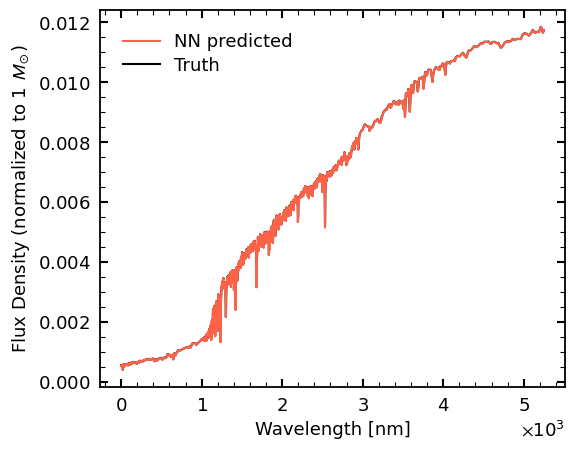

In [109]:
plt.plot(_specs[707], label='NN predicted', alpha=1, color='tomato', zorder=3)
plt.plot(10**log_spec_all[707], label='Truth', alpha=1, color='k')

plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel(r'Flux Density (normalized to 1 $M_\odot$)')

### From spectrum to magnitudes

Interpolate transmission curves to `self.transmission_effiency`, then integrate over spectrum 

In [36]:
# SDSS
_mag = speculator.predict_mag(params, 
                              log_stellar_mass=None,#np.ones(5) * 1e10,
                              redshift=None,#np.linspace(0, 0, 5),
                              filterset=['sdss_{0}0'.format(b) for b in 'ugriz'])

In [37]:
phot_all = np.load('./train_sed/phot_all.npy')[~zero_flag]
mag = -2.5 * np.log10(phot_all)

In [38]:
diff = (mag - _mag.cpu().detach().numpy()) / mag * 100
diff = diff[val_ind]

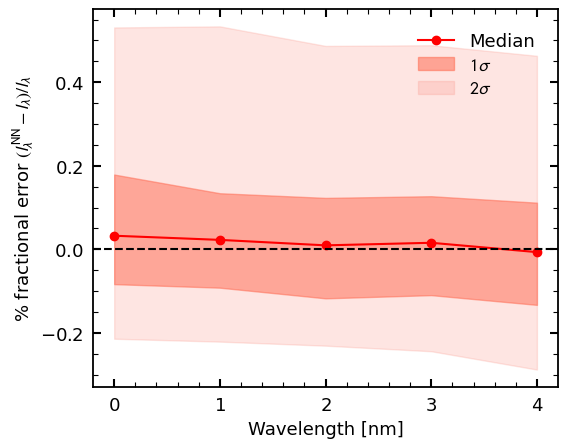

In [39]:
x = [0, 1, 2, 3, 4]
plt.plot(x, np.median(diff, axis=0), marker='o', color='r', label='Median')
plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.axhline(0, color='k', ls='--')
plt.legend()
